In [1]:
%load_ext line_profiler
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
env = gym_super_mario_bros.make("SuperMarioBros-v0", render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [5]:
s_size = env.observation_space.shape
a_size = env.action_space.n
print(env.observation_space.shape, s_size, a_size)

(4, 84, 84) (4, 84, 84) 7


In [6]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        # Code Here
        self.cnn = self.__build_cnn(4, a_size, h_size)

    def forward(self, x):
        # Define the forward process here (with ReLU activation for the first 2 layers)
        # x -> fc1 -> ReLU -> fc2 -> ReLU -> fc3
        # Code Here
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)

        # We output the softmax
        return F.softmax(self.cnn(x), dim=1)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def __build_cnn(self, c, output_dim, hidden_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            # nn.Flatten(),
            # nn.Linear(1296, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=min(print_every, 100))
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset() # Code Here: reset the environment
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state) # Code Here: get the action
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action) # Code Here: take an env step
            rewards.append(reward)
            if done:
                break
        print(f'finished run {i_episode}')
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        ## We compute this starting from the last timestep to the first, to avoid redundant computations

        ## appendleft() function of queues appends to the position 0
        ## We use deque instead of lists to reduce the time complexity

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(rewards[t] + gamma * disc_return_t) # Code Here: complete here

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [8]:
mario_params = {
    "h_size": 512,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 0.00025,#1e-4,
    "state_space": s_size,
    "action_space": a_size,
}

In [9]:
mario_policy = Policy(mario_params["state_space"], mario_params["action_space"], mario_params["h_size"]).to(device)
mario_optimizer = optim.Adam(mario_policy.parameters(), lr=mario_params["lr"])

In [10]:
# %lprun -f reinforce reinforce(mario_policy, mario_optimizer, mario_params["n_training_episodes"], mario_params["max_t"], mario_params["gamma"], 1)
scores = reinforce(mario_policy,
                   mario_optimizer,
                   mario_params["n_training_episodes"],
                   mario_params["max_t"],
                   mario_params["gamma"],
                   10)

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


finished run 1
finished run 2
finished run 3
finished run 4
finished run 5
finished run 6
finished run 7
finished run 8
finished run 9
finished run 10
Episode 10	Average Score: 1477.80
finished run 11
finished run 12
finished run 13
finished run 14
finished run 15
finished run 16
finished run 17
finished run 18
finished run 19
finished run 20
Episode 20	Average Score: 1664.00
finished run 21
finished run 22
finished run 23
finished run 24
finished run 25
finished run 26
finished run 27
finished run 28
finished run 29
finished run 30
Episode 30	Average Score: 2219.70
finished run 31
finished run 32
finished run 33
finished run 34
finished run 35
finished run 36
finished run 37
finished run 38
finished run 39
finished run 40
Episode 40	Average Score: 1568.10
finished run 41
finished run 42
finished run 43
finished run 44
finished run 45
finished run 46
finished run 47
finished run 48
finished run 49
finished run 50
Episode 50	Average Score: 1662.50
finished run 51
finished run 52
finishe

In [14]:
def record_video(env, policy, out_directory, fps=30, max_frames = 1000):
  images = []
  done = False
  state, _ = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = policy.act(state)
    state, reward, done, tunc, info = env.step(action)
    img = env.render()
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [15]:
record_video(env, mario_policy, './replay.mp4', 30)

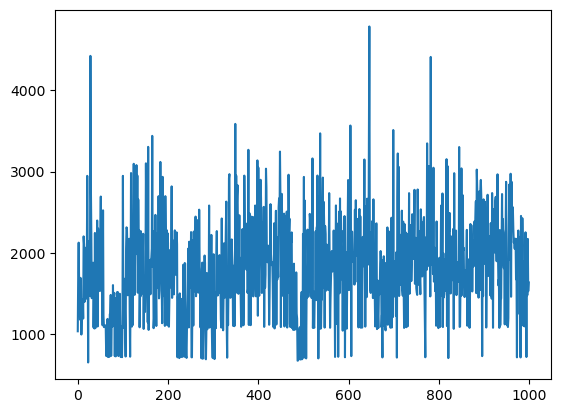

In [13]:
plt.plot(scores)